# 6주차 스터디 

    1. 시계열 데이터(주가) 다루기 
    
    2. 머신러닝(비지도학습): 주성분분석 (PCA) / 군집분석(Clustering)

**Made by 35기 코딩부장 류제현**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

### 1. 시계열 데이터 다루기 

In [2]:
# 주가 데이터를 불러오겠습니다
samsung = pd.read_csv("삼성전자주가.csv", index_col=0,
                 parse_dates=True)
oi = pd.read_csv("삼성전자영업이익.csv", index_col=0, 
                 parse_dates=True)

samsung

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-31,46650,47050,46150,46150,21621145
2019-02-01,46650,46950,46250,46350,13832454
2019-02-07,46800,47100,46200,46200,15872001
2019-02-08,45700,45700,44650,44800,12689196
2019-02-11,44500,45000,44250,45000,11125044
...,...,...,...,...,...
2022-12-23,58200,58400,57700,58100,9829407
2022-12-26,58000,58100,57700,57900,6756411
2022-12-27,58000,58400,57900,58100,10667027


In [3]:
# 영업이익(Operating Income) 데이터는 이렇게 생겼습니다
oi

# 주가는 Daily, 영업이익은 Quartly 데이터입니다. 이 둘을 어떻게 합쳐야 할까요?

,O_I
2019-01-31,1.080060e+10
2019-04-30,6.233282e+09
2019-07-31,6.597065e+09
2019-10-31,7.777892e+09
2020-01-31,7.160270e+09
2020-04-29,6.447345e+09
2020-07-31,8.146292e+09
2020-10-30,1.235324e+10
2021-01-29,9.047001e+09
2021-04-30,9.382868e+09


In [ ]:
# concat을 하면 됩니다. Pandas는 똑똑해서 index를 datetime으로만 지정해 둔다면 알아서 날짜를 맞춰 결합합니다
concat_df = pd.concat([samsung, oi], axis=1)
concat_df

    1-1) 시계열 누락값 다루기

* Forward Fill : 현재의 값을 미래에 Fill 해줌

* Back Fill : 미래의 값을 현재로 Fill 해준다

In [ ]:
# ffill: Forward Fill(현재의 값을 Forward함)
## Forward-Look Bias를 제거하려면 이 경우에는 ffill해줘야겠죠?
concat_df.ffill()

In [ ]:
# ffill 해준 영업이익을 plot으로 확인합시다
concat_df["O_I"].ffill().plot();

In [ ]:
# Back Fill(미래의 값을 Back 시킴)
## 금융에서는 적합하지 않은 방식입니다.
concat_df.bfill()

    1-2) 이동평균 (Moving Average)

주식에 관심 많으신 분들에게는 익숙한 이동평균

앞서 배운 ffill/bfill 과 같이 NaN 값을 채우는 데에도 MA가 사용되고는 합니다

일반적으로 노이즈가 많은 데이터의 경우 ffill/bfill 보다는 이동평균을 사용합니다 (평균은 노이즈의 일부를 제거해줍니다)

In [ ]:
# 20일 이동평균선을 그려보겠습니다
# 삼성전자의 Close(종가)만 사용하겠습니다
samsung_close = samsung[["Close"]].copy() 
samsung_close

In [ ]:
# Pandas rolling 함수는 window를 하루 단위로 이동합니다 (step 지정가능, default가 1칸(하루))
## 지금 경우에는 window=20 , mean()으로 20일 이동평균을 구해보겠습니다
samsung_close["ma20"] = samsung_close.Close.rolling(window=20).mean()
samsung_close

In [ ]:
# 시각화 
samsung_close.plot(figsize=(24,12));

    1-3) 시계열 분해

이건 그냥 

1. url로도 데이터를 가져올 수 있다

2. statsmodels 이라는 통계 전문 라이브러리가 있다

라는 걸 보여주기 위해서 추가했습니다

In [ ]:
# 데이터 불러오기
url = "https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/AirPassengers.csv"
air = pd.read_csv(url, names=['Date', 'Passengers'], 
                  index_col=0, parse_dates=True)

air

In [ ]:
air.plot();

In [ ]:
# 시계열 자료를 추세, 계절적 요소, 잔차로 분해해보자
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(air)
result.plot(); 

In [ ]:
result.trend[10:20]  #  trend, seasonal, resid  출력가능   

### 2. 비지도학습 (Unsupervised Learning)

지금까지는 항상 X와 y(정답지)가 함께 주어진 지도학습만 사용했습니다

오늘은 정답지(y)없이 X(피쳐)만 가지고 학습을 하는 비지도학습을 배워보겠습니다

비지도학습의 종류에는 군집분석(Clustering), 차원축소(Dimension Reduction)이 있습니다

    2-1) 주성분분석(PCA)

* 차원축소의 기법 중 하나

* 데이터의 분산을 최대한 보존하는 방향으로 데이터의 차원을 축소

* 차원을 축소시키고 학습하면 학습 시간이 줄어든다는 장점이 있다. 하지만, 반대 급부로 정확도는 감소한다 (항상 그런건 아니다)

* 매우 중요한 알고리즘이나 설명력이 중요한 금융 데이터에서는 잘 사용되지 않는다

In [ ]:
# 3차원 데이터 생성
m = 1000
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [ ]:
# 3차원 데이터를 시각화 해봅시다
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], marker='o', s=15); # s: 점의 사이즈 / marker="*", "^" 등을 시도해보세요

In [ ]:
# 싸이킷런을 사용한 PCA
from sklearn.decomposition import PCA

# (n_components=2 -> 두 개의 차원으로 축소)
## pca도 fit 해주고, transform 해줘야합니다
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1]);

In [ ]:
# 설명된 데이터의 분산의 비율     # 3차원 데이터를 2차원으로 줄였기 때문에, 분산을 100% 설명하지 못하는 것을 확인할 수 있습니다
pca.explained_variance_ratio_ , sum(pca.explained_variance_ratio_)

    PCA로 차원을 줄인 데이터셋 VS 일반 데이터셋

In [ ]:
from sklearn.datasets import fetch_openml

# Mnist 데이터셋을 불러온다
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X.shape, y.shape

In [ ]:
from sklearn.model_selection import train_test_split

# Train_set과 Test-set으로 분리한다
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# PCA로 차원을 축소한다
pca = PCA(n_components=0.95) # 분산의 95%를 보전 (정수로 개수를 지정할 수도 있고, 지금처럼 분산의 %를 지정해 줄 수도 있습니다)
X_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [ ]:
# 그냥 학습하는 경우 (+ 로지스틱 회귀란?)
import time
from sklearn.linear_model import LogisticRegression

# 정답지가 여러개가 있는 multiclass라서 "다중 분류" 문제
log_clf = LogisticRegression(multi_class="multinomial")

t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

# 걸린시간 출력
print(t1-t0)

In [ ]:
# 정확도 확인
log_clf.score(X_test, y_test)

In [ ]:
# PCA로 차원을 줄인 데이터로 학습할 경우
log_clf_pca = LogisticRegression(multi_class="multinomial")

t0 = time.time()
log_clf_pca.fit(X_reduced, y_train)
t1 = time.time()

# 걸린시간 출력
print(t1-t0)

In [ ]:
# PCA로 차원을 축소시킨 모형의 정확도 확인
log_clf_pca.score(X_test_reduced, y_test)

## 학습시간은 줄었지만, 모델의 정확도는 감소한 것을 확인할 수 있습니다

    2-2) K-means

* 가장 대표적인 군집분석 알고리즘

* K(군집의 수)를 미리 지정해야함 (하이퍼파라미터) -> k 결정을 위한 많은 수학적 방법론이 있음

* 비지도학습이라 정답지(y)가 필요없다!!

In [2]:
# 데이터를 불러오겠습니다
df = pd.read_csv("new_us_etf_stock.csv", index_col=0, parse_dates=True)
df

,Code,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1980-12-12,AAPL,0.513393,0.515625,0.513393,0.513393,0.410525,117258400.0
1980-12-15,AAPL,0.488839,0.488839,0.486607,0.486607,0.389106,43971200.0
1980-12-16,AAPL,0.453125,0.453125,0.450893,0.450893,0.360548,26432000.0
1980-12-17,AAPL,0.462054,0.464286,0.462054,0.462054,0.369472,21610400.0
1980-12-18,AAPL,0.475446,0.477679,0.475446,0.475446,0.380182,18362400.0
...,...,...,...,...,...,...,...
2019-06-18,WMT,109.800003,109.959999,108.910004,109.650002,109.650002,4911200.0
2019-06-19,WMT,109.800003,109.839996,108.870003,109.620003,109.620003,3924600.0
2019-06-20,WMT,109.820000,110.489998,109.279999,110.320000,110.320000,5001500.0


In [3]:
# pandas의 pivot_table을 사용해서 데이터를 사용하기 좋게 전처리 해주겠습니다
## 어떤 데이터를 쓸지, 값(values)에는 뭐가 들어갈지, index에는 뭐가 들어갈지, columns에는 뭐가 들어갈지 지정해주면 됩니다
pivot = pd.pivot_table(data=df, values="Close",
                       index=df.index, columns="Code")

pivot

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
1972-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.064453
1972-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.064209
1972-08-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063477
1972-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063477
1972-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,198.449997,1901.369995,82.589996,23.670000,127.120003,36.700001,135.160004,14.0500,292.399994,50.540001,11.25,109.650002
2019-06-19,197.869995,1908.790039,82.870003,24.000000,127.889999,36.779999,135.690002,14.1700,293.059998,50.040001,11.33,109.620003
2019-06-20,199.460007,1918.189941,83.000000,25.049999,131.110001,36.959999,136.949997,14.4500,295.859985,49.320000,11.85,110.320000


In [4]:
# NaN값이 없는 -> 즉, 모든 대상 주식이 거래되고 있는 기간만 사용하겠습니다
full_df = pivot.dropna()
full_df

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-18,44.061428,164.169998,81.739998,59.029999,132.089996,34.189999,25.840000,26.350000,119.959999,46.740002,35.500000,53.980000
2010-11-19,43.818573,164.820007,81.760002,59.279999,132.199997,34.259998,25.690001,26.740000,120.290001,46.779999,35.220001,54.389999
2010-11-22,44.765713,170.389999,82.000000,60.029999,133.479996,34.080002,25.730000,27.170000,120.190002,46.340000,35.049999,54.380001
2010-11-23,44.104286,168.199997,82.019997,59.619999,134.410004,33.250000,25.120001,26.870001,118.449997,45.740002,34.950001,53.669998
2010-11-24,44.971428,177.250000,81.629997,59.669998,134.179993,33.480000,25.370001,26.940001,120.199997,46.810001,36.080002,54.009998
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,198.449997,1901.369995,82.589996,23.670000,127.120003,36.700001,135.160004,14.050000,292.399994,50.540001,11.250000,109.650002
2019-06-19,197.869995,1908.790039,82.870003,24.000000,127.889999,36.779999,135.690002,14.170000,293.059998,50.040001,11.330000,109.620003
2019-06-20,199.460007,1918.189941,83.000000,25.049999,131.110001,36.959999,136.949997,14.450000,295.859985,49.320000,11.850000,110.320000


In [5]:
# k-means Clustering 데이터의 scale에 민감합니다
## 각 주가를 첫날 가격으로 나눠서 시작일(2010-11-18) 가격을 1로 맞춰주겠습니다
full_df_pp = full_df / full_df.iloc[0,:]
full_df_pp

Code,AAPL,AMZN,BND,GDX,GLD,GM,MSFT,SLV,SPY,USM,USO,WMT
Date,,,,,,,,,,,,
2010-11-18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2010-11-19,0.994488,1.003959,1.000245,1.004235,1.000833,1.002047,0.994195,1.014801,1.002751,1.000856,0.992113,1.007595
2010-11-22,1.015984,1.037888,1.003181,1.016941,1.010523,0.996783,0.995743,1.031120,1.001917,0.991442,0.987324,1.007410
2010-11-23,1.000973,1.024548,1.003425,1.009995,1.017564,0.972507,0.972136,1.019734,0.987412,0.978605,0.984507,0.994257
2010-11-24,1.020653,1.079674,0.998654,1.010842,1.015823,0.979234,0.981811,1.022391,1.002001,1.001498,1.016338,1.000556
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-18,4.503939,11.581714,1.010399,0.400983,0.962374,1.073413,5.230650,0.533207,2.437479,1.081301,0.316901,2.031308
2019-06-19,4.490776,11.626912,1.013824,0.406573,0.968204,1.075753,5.251161,0.537761,2.442981,1.070603,0.319155,2.030752
2019-06-20,4.526862,11.684169,1.015415,0.424360,0.992581,1.081018,5.299922,0.548387,2.466322,1.055199,0.333803,2.043720


In [6]:
# 데이터를 Transpose 해주어야 합니다
full_df_pp.T

Date,2010-11-18,2010-11-19,2010-11-22,2010-11-23,2010-11-24,2010-11-26,2010-11-29,2010-11-30,2010-12-01,2010-12-02,...,2019-06-11,2019-06-12,2019-06-13,2019-06-14,2019-06-17,2019-06-18,2019-06-19,2019-06-20,2019-06-21,2019-06-24
Code,,,,,,,,,,,,,,,,,,,,,
AAPL,1.0,0.994488,1.015984,1.000973,1.020653,1.021301,1.027364,1.008819,1.025841,1.031514,...,4.421327,4.407256,4.406348,4.374348,4.400447,4.503939,4.490776,4.526862,4.511429,4.520280
AMZN,1.0,1.003959,1.037888,1.024548,1.079674,1.079369,1.093318,1.068405,1.075410,1.075288,...,11.352257,11.301212,11.392459,11.388622,11.488275,11.581714,11.626912,11.684169,11.642201,11.621818
BND,1.0,1.000245,1.003181,1.003425,0.998654,1.000979,1.001713,1.002080,0.993271,0.992415,...,1.004527,1.006239,1.007952,1.008074,1.008074,1.010399,1.013824,1.015415,1.012601,1.014436
GDX,1.0,1.004235,1.016941,1.009995,1.010842,0.992885,0.997290,1.007962,1.021176,1.036422,...,0.382687,0.388955,0.393698,0.395223,0.397425,0.400983,0.406573,0.424360,0.427071,0.435431
GLD,1.0,1.000833,1.010523,1.017564,1.015823,1.007722,1.010750,1.025210,1.024907,1.023545,...,0.947687,0.952608,0.958437,0.958135,0.957529,0.962374,0.968204,0.992581,0.999167,1.010689
GM,1.0,1.002047,0.996783,0.972507,0.979234,0.988593,0.988593,1.000293,1.017257,1.014332,...,1.058789,1.043287,1.053524,1.042995,1.057034,1.073413,1.075753,1.081018,1.079848,1.076777
MSFT,1.0,0.994195,0.995743,0.972136,0.981811,0.977167,0.979489,0.977554,1.007740,1.040635,...,5.112229,5.088622,5.120743,5.125774,5.141254,5.230650,5.251161,5.299922,5.300697,5.351780
SLV,1.0,1.014801,1.031120,1.019734,1.022391,0.991651,1.007590,1.041366,1.055408,1.059962,...,0.524099,0.525237,0.529791,0.527894,0.527514,0.533207,0.537761,0.548387,0.544972,0.547738
SPY,1.0,1.002751,1.001917,0.987412,1.002001,0.990330,0.993331,0.987746,1.008753,1.021674,...,2.408303,2.404051,2.413971,2.411304,2.412221,2.437479,2.442981,2.466322,2.450817,2.447816


In [14]:
# Clustering을 해보겠습니다
from sklearn.cluster import KMeans

kmean = KMeans(n_clusters=3, n_init=1000, max_iter=500)  
# n_cluster:클러스터의 수 / n_init: 초기 중심 시작점 초기화 횟수 / max_iter : 중심점 최대 이동 횟수
                                                          
kmean.fit(full_df_pp.T) # 비지도학습이기 때문에 정답지(y)가 필요없습니다

c:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


KMeans(max_iter=500, n_clusters=3, n_init=1000)

In [15]:
# 각각이 할당된 군집입니다
kmean.labels_

array([2, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0])

In [16]:
# 각 주식이 어떤 클러스터에 할당 되었는지 확인해봅시다
stock = full_df_pp.columns
label = kmean.labels_

cluster = pd.Series(label, index=stock)
cluster

Code
AAPL    2
AMZN    1
BND     0
GDX     0
GLD     0
GM      0
MSFT    2
SLV     0
SPY     2
USM     0
USO     0
WMT     0
dtype: int32

In [17]:
# 진짜 주가의 흐름이 비슷한 모습을 보이는 지 확인해봅시다

## 우선 각 클러스터별로 분리해줍시다
c0 = cluster.loc[cluster == 0]
c1 = cluster.loc[cluster == 1]
c2 = cluster.loc[cluster == 2]

In [23]:
c1

Code
AMZN    1
dtype: int32

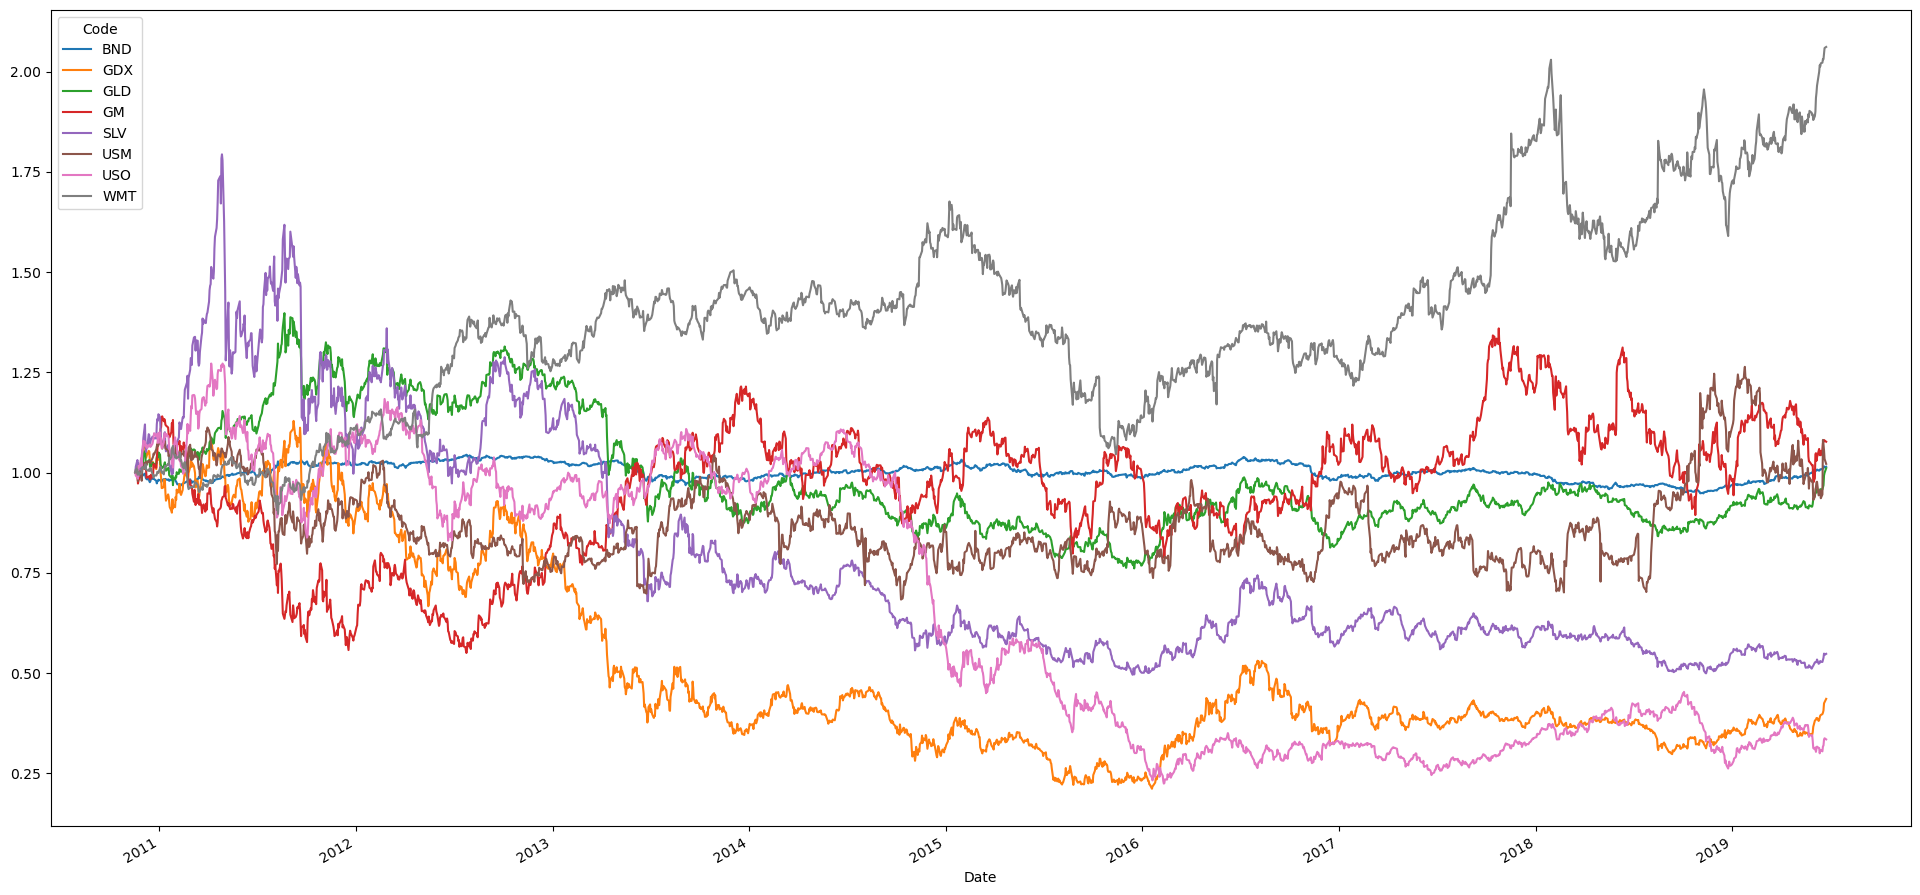

In [19]:
# 시각화해봅시다

## 클러스터 0
full_df_pp[list(c0.index)].plot(figsize=(24,12));

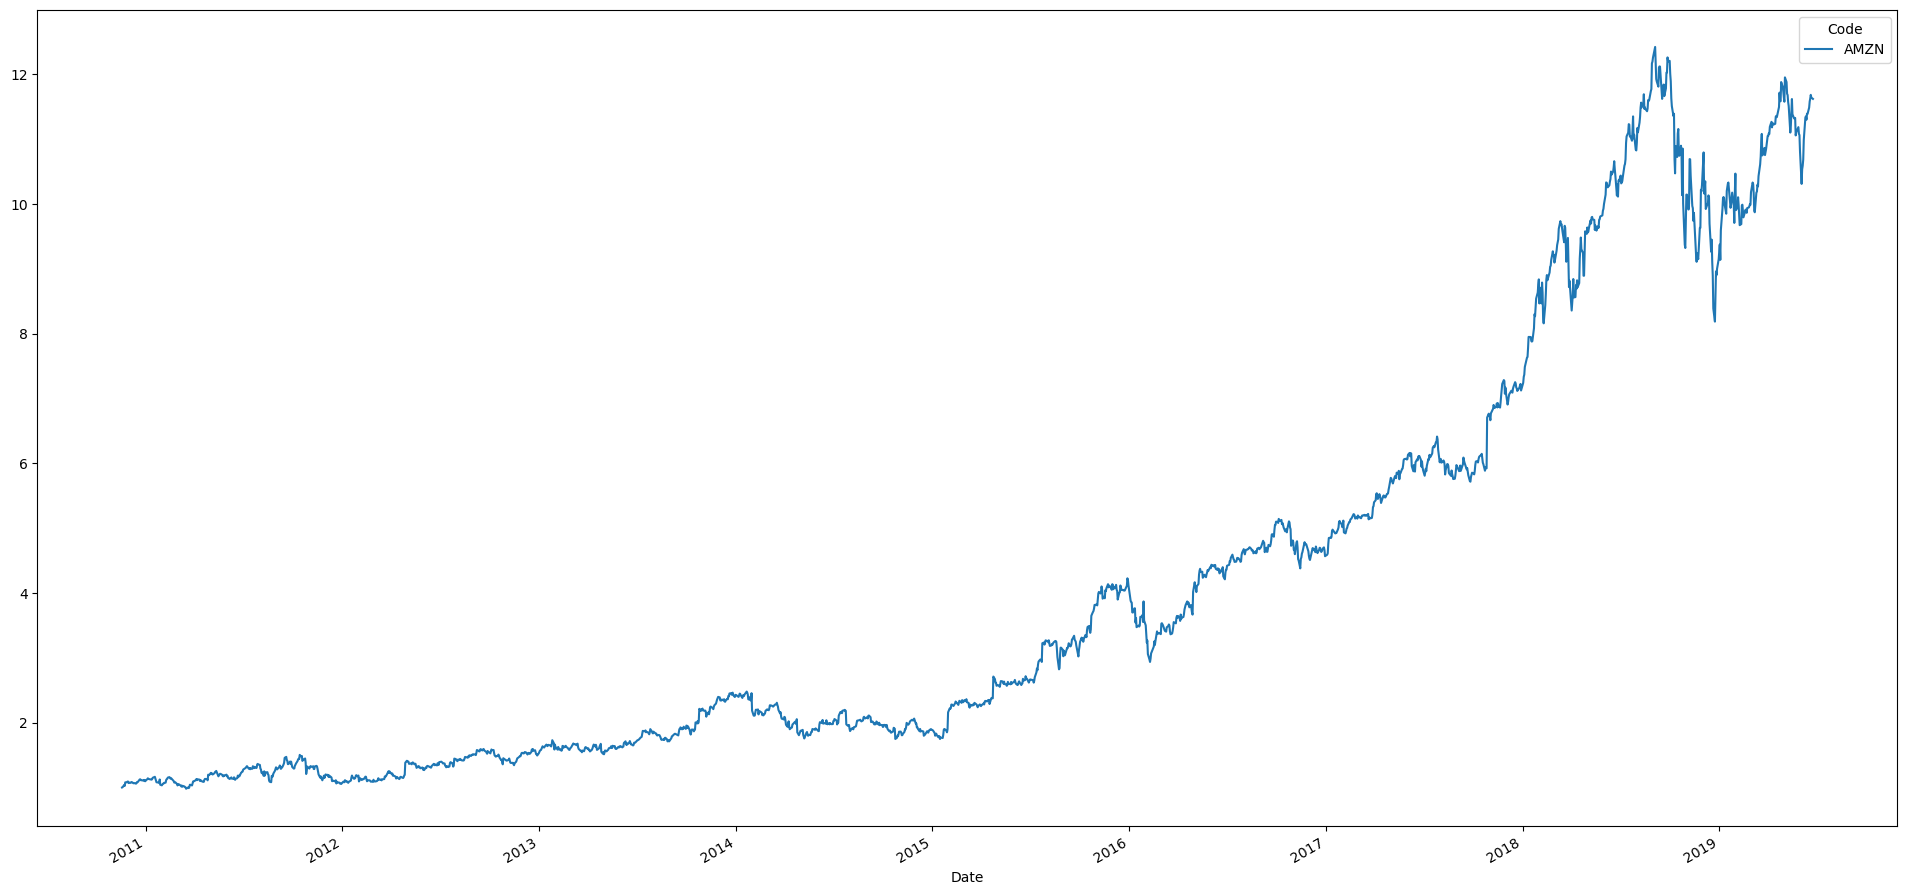

In [20]:
# 클러스터 1
full_df_pp[list(c1.index)].plot(figsize=(24,12));

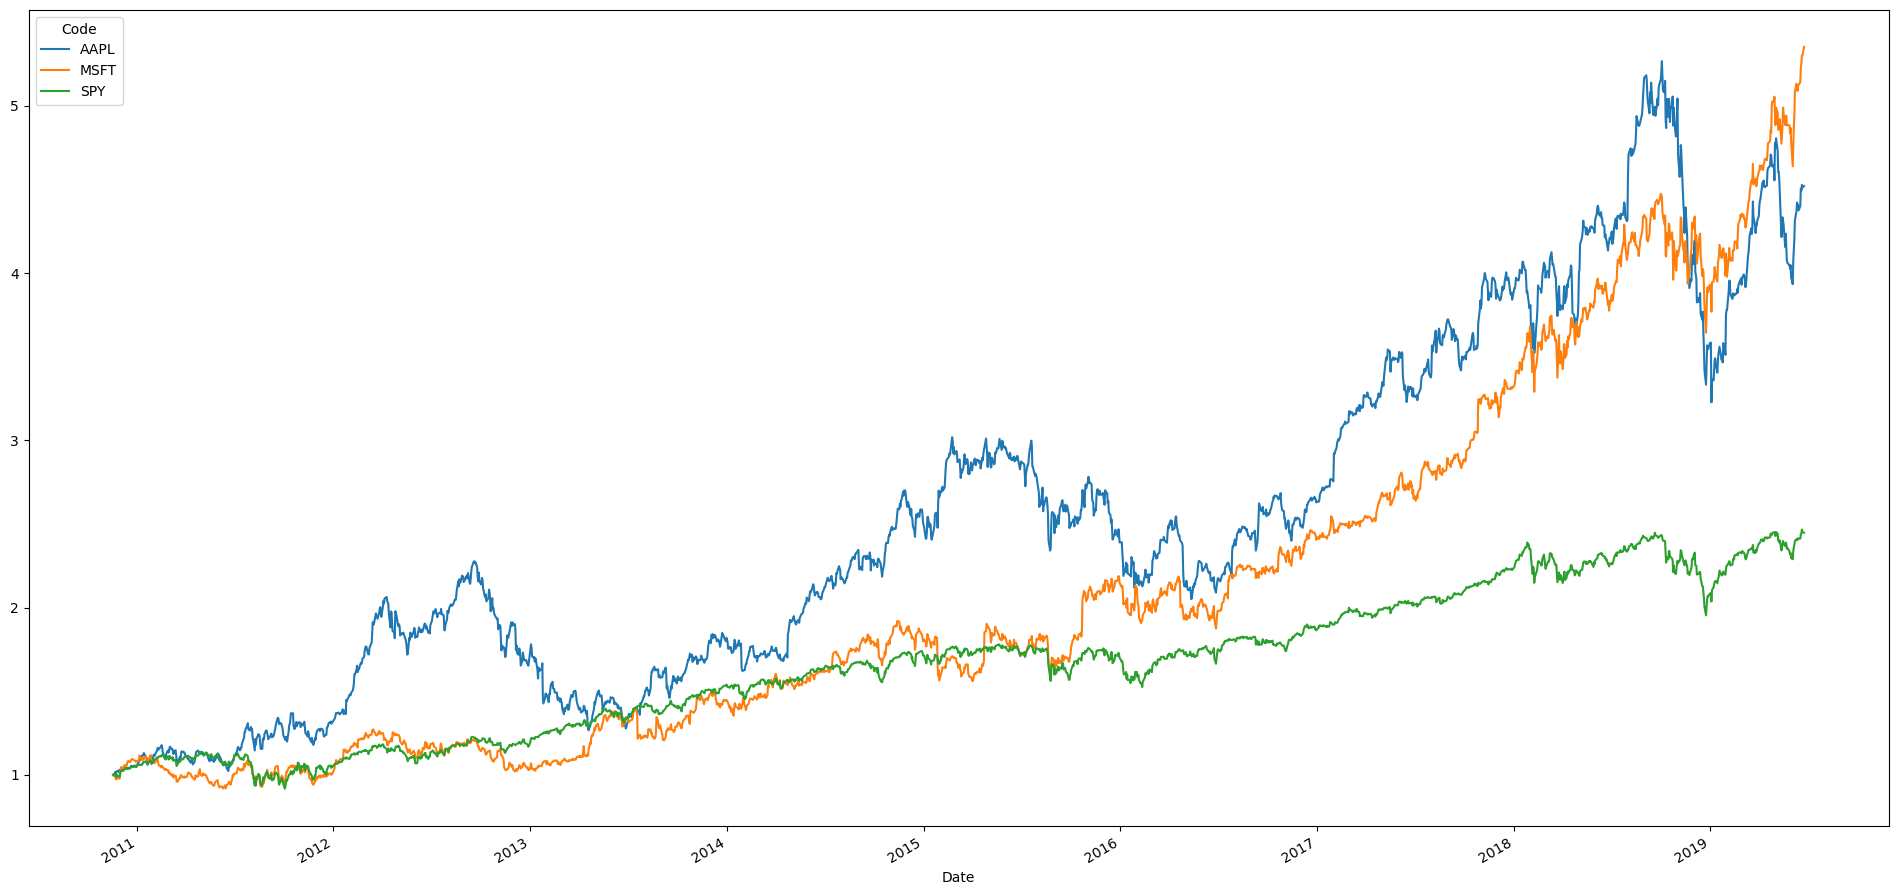

In [22]:
# 클러스터 2
full_df_pp[list(c2.index)].plot(figsize=(24,12));